### ***`Split Data`***
Splitting Data To Train, Validate & Test with Ratio 80% : 10% : 10%

In [ ]:
import os
import shutil
import splitfolders

loc = "IMG_CLASSES"
split_dir = "Split"

# Check if the "Split" directory exists and clear it if it does
if os.path.exists(split_dir):
    shutil.rmtree(split_dir)

# Create necessary subdirectories
os.makedirs(os.path.join(split_dir, 'train'))
os.makedirs(os.path.join(split_dir, 'val'))
os.makedirs(os.path.join(split_dir, 'test'))

# Perform the folder split
splitfolders.ratio(loc, output=split_dir, seed=42, ratio=(0.80, 0.10, 0.10))

Copying files: 17957 files [00:31, 568.33 files/s]


### ***`Preparing Data`***

##### Hyperparameters

In [ ]:
IMG_SIZE = 224
Batch_Size = 16
Learning_Rate = 0.0001
Epochs = 70

##### Loading Data

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
# Directories
train_dir="./Split/train"
test_dir="./Split/test"
val_dir="./Split/val"
# Load
train_data=image_dataset_from_directory(train_dir,batch_size=Batch_Size,image_size=(IMG_SIZE,IMG_SIZE),label_mode='categorical',shuffle=True,seed=42)
test_data=image_dataset_from_directory(test_dir,batch_size=Batch_Size,image_size=(IMG_SIZE,IMG_SIZE),label_mode='categorical',shuffle=False,seed=42)
val_data=image_dataset_from_directory(val_dir,batch_size=Batch_Size,image_size=(IMG_SIZE,IMG_SIZE),label_mode='categorical',shuffle=False,seed=42)
# Class Names
class_names = train_data.class_names
class_names

Found 14364 files belonging to 5 classes.
Found 1799 files belonging to 5 classes.
Found 1794 files belonging to 5 classes.


['1. Eczema 1677',
 '2. Melanoma 15.75k',
 '4. Basal Cell Carcinoma (BCC) 3323',
 '5. Melanocytic Nevi (NV) - 7970',
 '8. Seborrheic Keratoses and other Benign Tumors - 1.8k']

In [ ]:
renamed_classes = []
for idx, class_name in enumerate(class_names, start=1):
    # Extracting the number from the original class name
    original_number = class_name.split('.')[0].strip()
    # Creating the new class name
    new_class_name = f'Class {original_number}'
    renamed_classes.append(new_class_name)
renamed_classes

['Class 1', 'Class 2', 'Class 4', 'Class 5', 'Class 8']

### ***`Model`***

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adamss
import tensorflow as tf

# Load the EfficientNetB2 model with ImageNet weights
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='max')

# Add custom layers on top of the base model
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(base_model.output)
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dense(128, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=42)(x)
output = Dense(5, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=Learning_Rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping, lr reduction, and model checkpoint callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
model_checkpoint = ModelCheckpoint(filepath='EfficientNet_5_chkpt.h5', save_best_only=True)

# Fit the model
history = model.fit(train_data, epochs=Epochs, validation_data=val_data, callbacks=[early_stop, lr_reduction, model_checkpoint])

Epoch 1/70
898/898 [==============================] - 115s 118ms/step - loss: 8.9165 - accuracy: 0.7794 - val_loss: 6.1766 - val_accuracy: 0.9103 - lr: 1.0000e-04
Epoch 2/70
898/898 [==============================] - 104s 116ms/step - loss: 4.4360 - accuracy: 0.9074 - val_loss: 2.8973 - val_accuracy: 0.9270 - lr: 1.0000e-04
Epoch 3/70
898/898 [==============================] - 105s 117ms/step - loss: 2.0048 - accuracy: 0.9340 - val_loss: 1.2085 - val_accuracy: 0.9543 - lr: 1.0000e-04
Epoch 4/70
898/898 [==============================] - 104s 116ms/step - loss: 0.9010 - accuracy: 0.9480 - val_loss: 0.5939 - val_accuracy: 0.9560 - lr: 1.0000e-04
Epoch 5/70
898/898 [==============================] - 104s 116ms/step - loss: 0.4956 - accuracy: 0.9632 - val_loss: 0.3771 - val_accuracy: 0.9705 - lr: 1.0000e-04
Epoch 6/70
898/898 [==============================] - 105s 116ms/step - loss: 0.3545 - accuracy: 0.9731 - val_loss: 0.3090 - val_accuracy: 0.9710 - lr: 1.0000e-04
Epoch 7/70
898/898 [==

### ***`Results`***

##### Train

In [ ]:
train_loss, train_acc = model.evaluate(train_data)
print('Training Accuracy:', round(train_acc*100, 2), '%')
print('train loss:', round(train_loss, 6))

898/898 [==============================] - 30s 33ms/step - loss: 0.0651 - accuracy: 0.9999
Training Accuracy: 99.99 %
train loss: 0.065075


##### Validate

In [ ]:
val_loss, val_acc = model.evaluate(val_data)
print('Validation Accuracy:', round(val_acc*100, 2), '%')
print('val loss:', round(val_loss,6))

113/113 [==============================] - 4s 34ms/step - loss: 0.1336 - accuracy: 0.9794
Validation Accuracy: 97.94 %
val loss: 0.133585


##### Test

In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print('test Accuracy:', round(test_acc*100, 2), '%')
print('test loss:', round(test_loss, 6))

113/113 [==============================] - 4s 36ms/step - loss: 0.1338 - accuracy: 0.9805
test Accuracy: 98.05 %
test loss: 0.133833


##### Confusion Matrix & Classification Report

113/113 [==============================] - 5s 35ms/step
Classification report
               precision    recall  f1-score   support

     Class 1       0.91      0.95      0.93       169
     Class 2       1.00      0.98      0.99       314
     Class 4       0.99      0.99      0.99       333
     Class 5       0.99      1.00      0.99       797
     Class 8       0.94      0.92      0.93       186

    accuracy                           0.98      1799
   macro avg       0.97      0.97      0.97      1799
weighted avg       0.98      0.98      0.98      1799



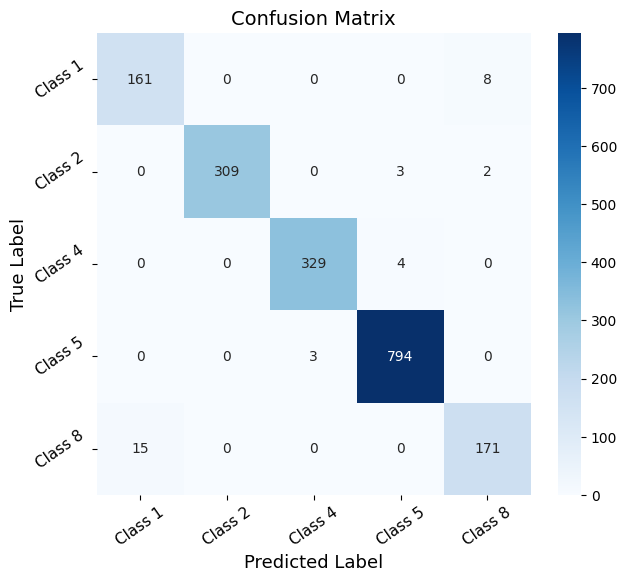

In [ ]:
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

pred_probs = model.predict(test_data)
pred_classes = pred_probs.argmax(axis =1)
y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
from sklearn.metrics import classification_report
print("Classification report\n",classification_report(y_labels,pred_classes, target_names=renamed_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_labels, pred_classes)
plt.figure(figsize=(7, 6))

heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=renamed_classes, yticklabels=renamed_classes)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=11, rotation=35)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=11, rotation=35)

plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=13)
plt.ylabel('True Label', fontsize=13)
plt.show()

##### Loss Plot

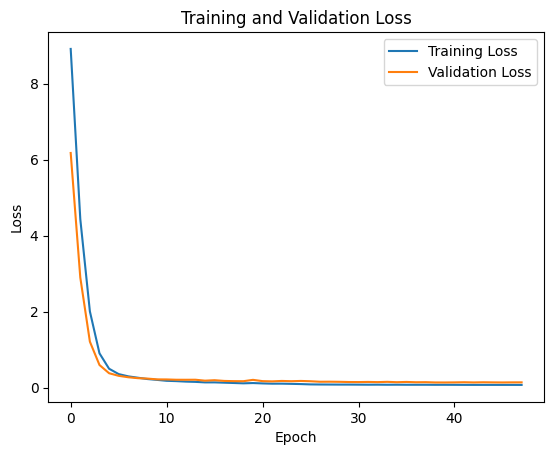

In [ ]:
import matplotlib.pyplot as plt

loss=history.history["loss"]
val_loss=history.history["val_loss"]

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

##### Saving Final Model & Notebook

In [ ]:
import os
import shutil
os.rename('EfficientNet_5_chkpt.h5', f'EfficientNet_5_({test_acc * 100:.2f}%).h5')
shutil.copyfile('Eff_Net_5.ipynb', f'EfficientNet_5_({test_acc * 100:.2f}%).ipynb')